# MNIST Experiment: T Off 20

In [1]:
import sys
sys.path.insert(1, '../_tools/')
import torch as th
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as trasf
from utils.tensordata import TDataset, TDataloader, PosNeg_Bootstrap_TDataloader
from utils.model_selection import GridSearchCV, RandomSearchCV, Fixed, LogUniform
from twomoon import TwoMoon
from ffa import FFA_withEntropy
import matplotlib.pyplot as plt

exp_name = 'T Off 20'

seed = 42
th.manual_seed(seed)
np.random.seed(seed)
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

### Data

In [2]:
DS_torch_dataset = torchvision.datasets.MNIST(
    root=r"C:\Users\matte\LocalData\Master Thesis",
    train=True,
    download=True,
    transform=trasf.ToTensor()
)
TS_torch_dataset = torchvision.datasets.MNIST(
    root=r"C:\Users\matte\LocalData\Master Thesis",
    train=False,
    download=True,
    transform=trasf.ToTensor()
)

# Load everything
DS = TDataset(
    x=th.stack([x.flatten() for x, y in DS_torch_dataset]).to(device),
    y=th.tensor([y for x, y in DS_torch_dataset], device=device).reshape(-1, 1)
)
TS = TDataset(
    x=th.stack([x.flatten() for x, y in TS_torch_dataset]).to(device),
    y=th.tensor([y for x, y in TS_torch_dataset], device=device).reshape(-1, 1)
)
TR, VL = DS.random_split(5/6)

# Dataloaders
batch_size = 128
DS_dl = DS.dataloader(batch_size=batch_size)
TR_dl = TR.dataloader(batch_size=batch_size)
VL_dl = VL.dataloader(batch_size=batch_size)
TS_dl = TS.dataloader(batch_size=batch_size)
TR_pndl = PosNeg_Bootstrap_TDataloader(TR, batch_size=batch_size)
DS_pndl = PosNeg_Bootstrap_TDataloader(DS, batch_size=batch_size)

### Model

In [3]:
Model = FFA_withEntropy

### Kernel Scale

The value found in the 'T on' experiment

In [4]:
kern_sc = 10.

***

### Preliminary Screening

***

### Model Selection + Final Retraining

In [5]:
grid = {
    'Nclasses': [10],
    'A': [(784+10, 20, 20, 20)],
    'f_hid': [nn.ReLU()],
    'lr_hot': [0.01],
    'lr_cold': [0.01],
    'momentum': [0.99], 
    'weight_decay': np.geomspace(1e-8, 1e-4, 5).tolist(),
    'temperature': [0],
    'kernel_scale': [kern_sc], # the value found in 'T on' experiment, to compare the value of H
    'Nepochs': [24]
}
ModelSelection = GridSearchCV(Model, grid, device)      
ModelSelection.run(TR_dl, VL_dl, TR_pndl)
ModelSelection.save("model selection results/" + exp_name + ".txt")
print(ModelSelection)
print("Note: E == 1 - accuracy")

# Final Retraining
M = Model(ModelSelection.results[0]['hyp']).to(device)
print('\n' + '-'*20 + "Final Retraining" + '-'*20)
M.fit(DS_pndl)
print(f"acc(TR) = {(1-M.TS_loop(DS_dl))*100:.3g} %")
th.save(M, 'final models/' + exp_name + '.pt')

GridSearchCV: 100%|███████████████████████████████████████████████████████████████████| 5/5 [1:18:14<00:00, 938.99s/it]


The winner is:
hyp: {
 Nclasses: 10,
 A: (794, 20, 20, 20),
 f_hid: ReLU(),
 lr_hot: 0.01,
 lr_cold: 0.01,
 momentum: 0.99,
 weight_decay: 0.0001,
 temperature: 0,
 kernel_scale: 10.0,
 Nepochs: 24,
}
E(VL) = 0.083
E(TR) = 0.0743
Note: E == 1 - accuracy

--------------------Final Retraining--------------------
acc(TR) = 91.6 %


***

### Analysis

Note: noisy curves are expected, due to bootstrap and random generation of different negative data at each epoch.

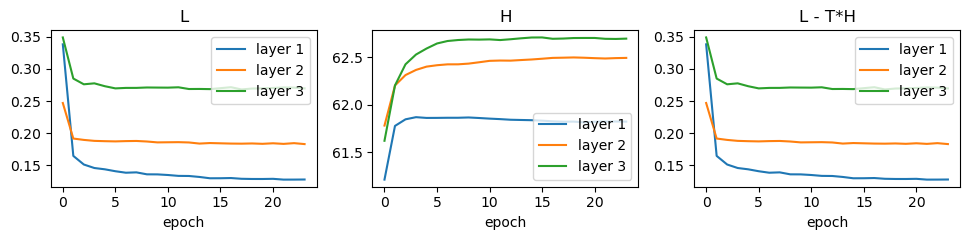

In [6]:
M = th.load('final models/' + exp_name + '.pt').to(device)
M.plot_curve()

In [7]:
gathers = [
    [1, 1, 1],
    [0, 1, 1],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]   
]
print("gather     accuracy%")
for gather in gathers:
    M.gather.data = th.tensor(gather, device=device).float()
    print(f"{gather}  {(1-M.TS_loop(TS_dl))*100:.5g}")

gather     accuracy%
[1, 1, 1]  92.53
[0, 1, 1]  91.6
[1, 0, 0]  92.54
[0, 1, 0]  91.75
[0, 0, 1]  84.87


#### Different initializations different results?

In [8]:
M = th.load('final models/' + exp_name + '.pt').to(device)

N_trials = 5
TS_acc = []
for i in range(N_trials):
    M.fit(DS_pndl)
    this_trial_results = []
    for gather in gathers:
        M.gather.data = th.tensor(gather, device=device).float()
        this_trial_results.append((1-M.TS_loop(TS_dl))*100)   
    TS_acc.append(this_trial_results)   
TS_acc = np.asarray(TS_acc)
TS_mean = np.mean(TS_acc, axis=0)
TS_std = np.std(TS_acc, axis=0, ddof=1)

print("gather     accuracy%")
for i in range(len(gathers)):
    print(f"{gathers[i]}  {TS_mean[i]:.5g} +- {TS_std[i]:.5g}")

gather     accuracy%
[1, 1, 1]  92.864 +- 0.15176
[0, 1, 1]  92.422 +- 0.26338
[1, 0, 0]  92.424 +- 0.11971
[0, 1, 0]  92.556 +- 0.31533
[0, 0, 1]  87.468 +- 1.763
